# Poisson pymc3 regression

Using the tips dataset

## Setup libraries

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import pandas as pd
import scipy.stats as st

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
import patsy

In [4]:
from numpy.random import default_rng

rng = default_rng()

In [5]:
warnings.simplefilter(
    action="ignore", category=(FutureWarning, DeprecationWarning)
)

## Plotting specifications

In [6]:
az.style.use("arviz-darkgrid")
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams["figure.dpi"] = 50
palette = sns.color_palette()

## Get data

In [7]:
raw_data = sns.load_dataset('tips')

In [8]:
raw_data.columns

Index(['total_bill', 'tip', 'sex', 'smoker', 'day', 'time', 'size'], dtype='object')

### Use column codes

In [9]:
df_raw = raw_data[['total_bill', 'tip', 'size']].copy()

In [10]:
df_raw['sex'] = raw_data.sex.cat.codes
df_raw['smoker'] = raw_data.smoker.cat.codes
df_raw['time'] = raw_data.time.cat.codes

In [11]:
df = pd.concat([df_raw, pd.get_dummies(raw_data.day).iloc[:, :-1]], axis=1)

In [12]:
df.head()

,total_bill,tip,size,sex,smoker,time,Thur,Fri,Sat
0,16.99,1.01,2,1,1,1,0,0,0
1,10.34,1.66,3,0,1,1,0,0,0
2,21.01,3.50,3,0,1,1,0,0,0
3,23.68,3.31,2,0,1,1,0,0,0
4,24.59,3.61,4,1,1,1,0,0,0


## Summarize data

In [13]:
df.shape

(244, 9)

<AxesSubplot:xlabel='total_bill', ylabel='Count'>

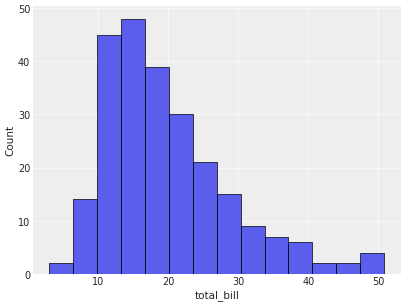

In [14]:
sns.histplot(df.total_bill)

In [15]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

## Create dmatrices

In [16]:
train_df.columns

Index(['total_bill', 'tip', 'size', 'sex', 'smoker', 'time', 'Thur', 'Fri',
       'Sat'],
      dtype='object')

In [17]:
fml = "total_bill ~ tip + size + sex + smoker + time + Thur + Fri + Sat"

In [18]:
outcome_dm, predictors_dm = patsy.dmatrices(fml, train_df)

In [19]:
outcome = outcome_dm.squeeze()

In [20]:
pdt = pd.DataFrame.from_records(
    predictors_dm[:, :], columns=predictors_dm.design_info.column_names
)

In [21]:
pdt.columns

Index(['Intercept', 'tip', 'size', 'sex', 'smoker', 'time', 'Thur', 'Fri',
       'Sat'],
      dtype='object')

## Setup model

In [22]:
with pm.Model() as model:

    # define priors, weakly informative Normal
    b0 = pm.Normal("Intercept", mu=0, sigma=10)
    b1 = pm.Normal("tip", mu=0, sigma=10)
    b2 = pm.Normal("size", mu=0, sigma=10)
    b3 = pm.Normal("sex", mu=0, sigma=10)
    b4 = pm.Normal("smoker", mu=0, sigma=10)
    b5 = pm.Normal("time", mu=0, sigma=10)
    b6 = pm.Normal("Thur", mu=0, sigma=10)
    b7 = pm.Normal("Fri", mu=0, sigma=10)
    b8 = pm.Normal("Sat", mu=0, sigma=10)

    # define linear model and exp link function
    theta = (
        b0
        + b1 * pdt.values[:, 1]
        + b2 * pdt.values[:, 2]
        + b3 * pdt.values[:, 3]
        + b4 * pdt.values[:, 4]
        + b5 * pdt.values[:, 5]
        + b6 * pdt.values[:, 6]
        + b7 * pdt.values[:, 7]
        + b8 * pdt.values[:, 8]
    )

    # y = pm.Poisson(
    #     "y", mu=np.exp(theta), observed=train_df["total_bill"].values
    # )
    
    y = pm.Normal(
        "y", mu=theta, observed=train_df["total_bill"].values
    )

## Run inference

In [23]:
with model:
    trace = pm.sample(4000, tune=2000, cores=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Sat, Fri, Thur, time, smoker, sex, size, tip, Intercept]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 54 seconds.


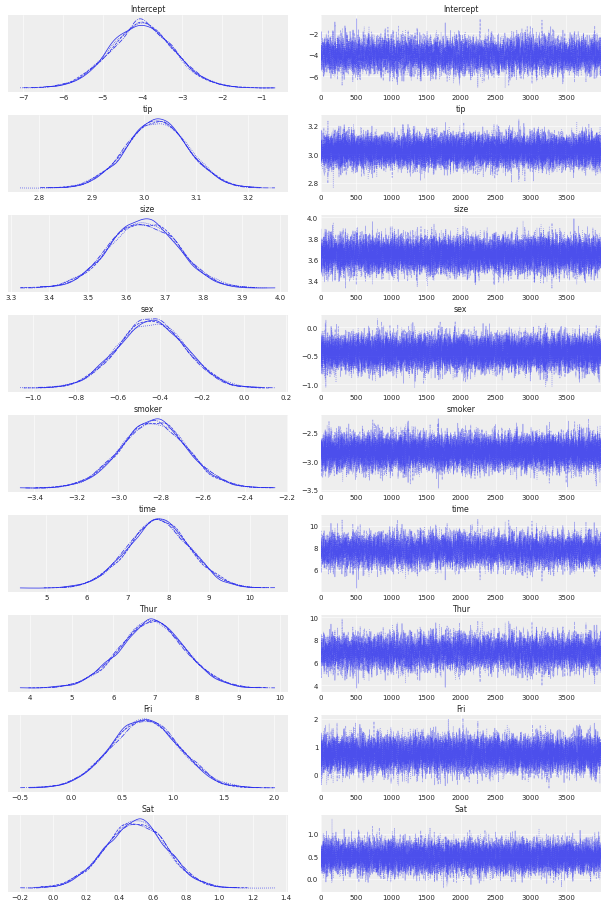

In [24]:
az.plot_trace(trace);

## Display results

In [25]:
trace_result = az.summary(trace.posterior)
trace_result

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-4.022,0.811,-5.516,-2.444,0.011,0.008,5413.0,7401.0,1.0
tip,3.025,0.060,2.914,3.139,0.000,0.000,14715.0,11625.0,1.0
size,3.645,0.088,3.477,3.807,0.001,0.001,13508.0,11179.0,1.0
sex,-0.442,0.158,-0.727,-0.135,0.001,0.001,18067.0,11354.0,1.0
smoker,-2.834,0.158,-3.126,-2.533,0.001,0.001,15766.0,10992.0,1.0
time,7.759,0.767,6.292,9.191,0.010,0.007,5760.0,7793.0,1.0
Thur,6.925,0.786,5.382,8.349,0.011,0.007,5580.0,7301.0,1.0
Fri,0.729,0.335,0.130,1.383,0.003,0.002,10153.0,10404.0,1.0
Sat,0.495,0.182,0.139,0.825,0.002,0.001,13519.0,11686.0,1.0


In [26]:
# betas = np.exp(trace_result['mean'])
betas = trace_result['mean']

In [27]:
betas

Intercept   -4.022
tip          3.025
size         3.645
sex         -0.442
smoker      -2.834
time         7.759
Thur         6.925
Fri          0.729
Sat          0.495
Name: mean, dtype: float64

In [28]:
X = np.concatenate(
    [
        np.ones((test_df.shape[0], 1)),
        test_df.drop(columns='total_bill').values,
    ],
    axis=1,
)

In [29]:
y_pred = np.sum(X * betas.values.T, axis=1)

In [30]:
y_test = test_df['total_bill']

<AxesSubplot:xlabel='total_bill'>

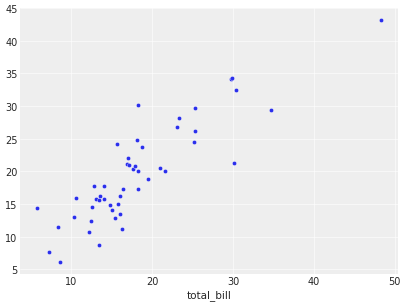

In [31]:
sns.scatterplot(y_test, y_pred)

In [32]:
mse = mean_squared_error(y_test, y_pred)

In [33]:
mse

17.44670879846939